### Train ML model using MOM6 data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
import sys
sys.path.append('../../modules/')

%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes

Working at scale:50
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_50km.zarr
Subsampling
Loaded from saved norm nc
Normalized data
loading
Test and train batches split. Number of batches: 37-5
Train loss step 0:  0.43096931459935933 test loss: 0.12442391812801361
Train loss step 20:  0.0085222013042988 test loss: 0.008934964239597321
Train loss step 40:  0.007189645444521228 test loss: 0.007473641727119684
Train loss step 60:  0.006674777577958397 test loss: 0.006998074147850275
Train loss step 80:  0.006433382617762765 test loss: 0.006645532883703708
Train loss step 100:  0.006222355355684822 test loss: 0.00642950451001525
Train loss step 120:  0.006113871491539317 test loss: 0.006256900168955326
Train loss step 140:  0.006082070651590018 test loss: 0.00621366361156106
Train loss step 160:  0.005995963775628322 test loss: 0.0061161966063082215
Train loss step 180:  0.005889907756165878 test loss: 0.00602689515799284
Train loss

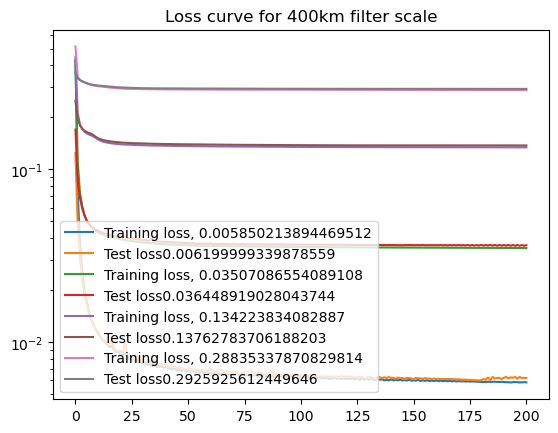

In [3]:
kind = 'MOM6'

MOM6_P2L_data = 'gs://leap-persistent/dhruvbalwada/MOM6/' 

#Lkeys  = ['100', '200', '400']
Lkeys  = ['50', '100', '200', '400']

for L in Lkeys: 
    print('Working at scale:' + L)
    Lint = int(L)
    #fname = f'{MITgcm_bucket}/ML_data/ds_ML_'+L+'km_3D'
    fname = f'{MOM6_P2L_data}Phillips2Layer/res4km_sponge10day_long_ml_data_'+L+'km.zarr'
    
    # Open dataset
    ML_data = datasets.MOM6_transformer(fname, Lint, 
                                      input_channels=['U_x', 'U_y', 
                                                      'V_x', 'V_y', 
                                                      'Sx', 'Sy'])
    ML_data.convert_subsampled_normed(exp_name='MOM6_P2L');
    ML_data.generate_test_train_batches();
    
    # Setup ML model
    ANN_model = ML_classes.ANN(shape=[36,36,2], num_in = len(ML_data.input_channels))
    regress_sys = ML_classes.RegressionSystem(ANN_model)
    
    regress_sys.train_system(ML_data, 201)
    
    ## Loss plot
    plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
    plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))

    plt.title('Loss curve for '+ L+ 'km filter scale')
    plt.grid()
    plt.yscale('log')
    plt.legend()

    plt.savefig('figures/MOM6_P2L_'+L+'km_loss_curve_36_36.png')
    
    # Save the checkpoint
    CKPT_DIR = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/ckpts_'+L+'_MOM6_P2L_36_36'#+'_'+str(bias)
    regress_sys.save_checkpoint(CKPT_DIR)
    
    # Save model nc file
    model_nc = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_model_ncs/' +'MOM6_P2L_'+L+'_36_36.nc'
    regress_sys.save_weights_nc(model_nc)